# SRGAN


SRGAN, представляет собой генерирующую состязательную сеть (GAN), которая может генерировать изображения сверхвысокого разрешения из изображений с низким разрешением с более мелкими деталями и более высоким качеством.

Как и любой другой GAN, SRGAN содержит сеть генератора и сеть дискриминатора. 
Обе сети глубокие. Функциональные возможности обеих этих сетей указаны следующим образом:


1.   Генератор:  принимает изображение с низким разрешением размером 
64x64x3 и после серии слоев свертки и повышающей дискретизации генерирует изображение со сверхвысоким разрешением в форме 256x256x3.
2.   Дискриминатор: принимает изображение с высоким разрешением и пытается определить, является ли данное изображение реальным (из реальных образцов данных) или поддельным (сгенерированным генератором).

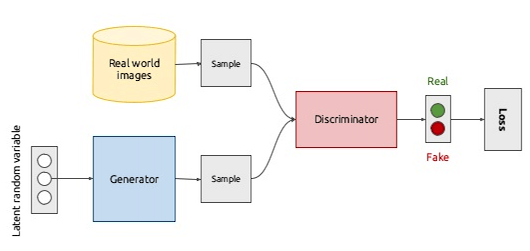

Рассмотрим детальнее архитектуру сети, точнее составляющих её моделей.


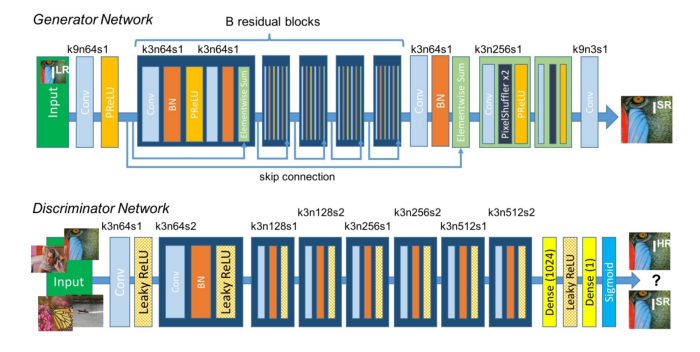

# Архитектура генератора:
*   pre-residual block
*   residual block
*   post-residual block
*   upsampling block
*   last convolution layer

Pre-residual block содержит свёрточный слой и нелинейный слой с функцией активацией ReLU.

Residual block содержит два свёрточных слоя, за каждым следует слой нормализации с momentum=0.8. В конце вычисляется сумма входного в блок тензора и выход последнего batch-norm слоя. Всего 16 residual block-ов.

Post-residual block содержит слой свёртки и слой нормализации с momentum=0.8.

Upsampling block состоит из одного upsampling слоя и одного свёрточного, с функцией активацией ReLU. Всего два upsampling block-ов.

Last convolution layer - свёрточный слой с функцией активацией tanh.



# Архитектура дискриминатора
Дискриминатор тоже глубокая свёрточная нейросеть. Содержит восемь свёрточных слоёв, следующих после двух полносвязных слоёв. После каждого блока свёртки - слой нормализации. В конце - два полносвязных слоя, работающих как классификатор. На выходе - вероятность принадлежности изображения, поданного на вход, к реальному датасету. Детальная конфигурация дискриминатора:



Теперь разберёмся с целевыми функциями.


# Целевая функция
Целевая функция для SRGAN называется **perceptual loss**, которая есть сумма двух лоссов:

*   Content loss
*   Adversarial loss




## Content loss
Есть два типа контент-лосса:

*   Pixel-wise MSE loss
*   VGG loss



### Pixel-wise MSE loss
Данный лосс показывает среднеквадратичную ошибку между каждым пикселем реального изображения и пикселем сгенерированного:

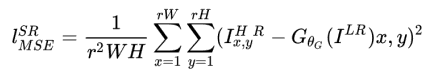

где G(I(LR)) - результат работы генератора - ожидаемое изображение высокого разрешения, I(HR) - образец из датасета изображений с высоким разрешением. 

### VGG loss
Промежуточные слои преобученной сети VGG19 извлекают признаки и поэтому могут быть использованиы для извлечения карт признаков сгенерированных и реальных изображений. VGG loss вычисляет Евклидово расстояние между этими картами признаков:

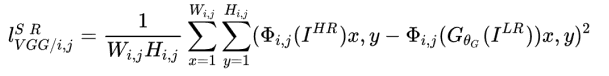

где Ф - символизирует карту признаков, созданных VGG19, Ф(I(HR)) - извлечённая карта признаков реального изображения, Ф(G(I(LR)))  - извлечённая карта признаков сгенерированного изображения.

Для реализации выбираем VGG loss.

## Adversarial loss
Adversarial loss(состязательный лосс) вычисляется дискриминатором по вероятностям правдободобия изображений генератора:


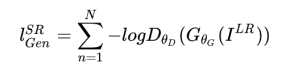

## Perceptual loss
Целевая функция - perceptual loss - взвешенная сумма content loss и adversarial loss:

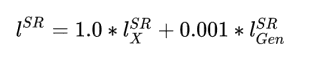

Минимизацией perceptual loss генератор пытается обмануть генератор. Когда величина perceptual loss уменьшается - значит, генератор начал генерировать правдоподобные изображения.

# Подготовка данных
Для обучения модели используем датасет CelebFaces Attributes (CelebA). В нём содержится 202 599 лиц знаменитостей.
Скачиваем и распакуем 

In [ ]:
!cp "/content/drive/My Drive/Datasets/img_align_celeba.zip" "dataset.zip"
!unzip -q  dataset.zip

### Подключаем необходимые модули.

In [ ]:
!pip install -r /content/drive/MyDrive/ColabNotebooks/SRGAN/requirements.txt

# Реализация модели SRGAN
SRGAN состоит из трёх нейросетей - генератора, дискриминатора и предобученной VGG19.


In [ ]:
!python /content/drive/MyDrive/ColabNotebooks/SRGAN/utils.py

In [ ]:
!python /content/drive/MyDrive/ColabNotebooks/SRGAN/networks.py

In [ ]:
!python /content/drive/MyDrive/ColabNotebooks/SRGAN/gan.py

In [ ]:
!python /content/drive/MyDrive/ColabNotebooks/SRGAN/train.py

# Оценка результатов
На некоторых изображениях наблюдаются артефакты(цветные пятна). Тональность генерируемых картинок отличается от исходного изображения.

# Посмотрим на работу генератора
Загружаем модель генератора(ниже это модель после 23 600 эпох обучения)

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/ColabNotebooks/SRGAN/models/generator.h5')

In [ ]:
import os
listu = os.listdir('/content/img_align_celeba') 
print(len(listu))

202599


Выбрав одно изображение, сжав его, подаём модели генератора.

In [ ]:
!pip install Pillow
!pip install scipy==1.1.0

In [2]:
from scipy.misc import imread
import numpy as np
from skimage.transform import resize
import random
num = random.randint(1,202599)
num = str(num)
if len(num)<6:
  num = '0'*(6 - len(num))+num
img = imread('/content/img_align_celeba/' + num + '.jpg')
img = img.astype(np.float32)
img = img / 127.5 - 1.
img = resize(img, (64, 64, 3))
img_to_gen = np.expand_dims(img, axis=0)
img_res = model.predict(img_to_gen)

Выведем для сравнения сжатое изображение(низкое разрешение) и результат работы генератора.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'From generator')

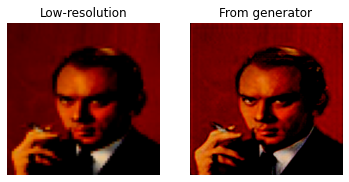

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(img_to_gen[0])
ax.axis("off")
ax.set_title("Low-resolution")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_res[0])
ax.axis("off")
ax.set_title("From generator")

## Использованные ресурсы:




https://hub.packtpub.com/using-srgans-to-generate-photo-realistic-images-tutorial/

https://github.com/apachecn/apachecn-dl-zh/blob/master/docs/gan-proj/5.md

https://github.com/deepak112/Keras-SRGAN